### Project "The Study of Uncertainty in forecasting Time Series" 
#### UE D: Deep Learning

Benjamin Richards<br>
Cauê Caviglioni

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
from scipy.stats import linregress

### 1) Problem Understading and Generation of Data
##### In the first part, it will be implemented a neural network that will predict the slope $\scriptstyle a$, the intercept $\scriptstyle b$ and the variance $\scriptstyle \sigma$ of the points given in the time-series $x(t)$ crossed with $x(t+1)$
##### Function `m`: State Evolution in the Lorenz-63 System

It was implemented the function `m` in order to simulate the evolution of the state of a Lorenz-63 system over a small time step. For that, the  4th-order Runge-Kutta integration method is used in ordet to calculate the future state of the system based on its current state.

##### Parameters
- **`x_past`**: The current state of the system, represented as a 3-dimensional vector `[x, y, z]`.

##### Physical Constants
- **`sigma`**: Represents the Prandtl number in the Lorenz-63 system.
- **`rho`**: Related to the horizontal temperature difference in the system.
- **`beta`**: Dissipation rate in the system.


In [2]:
# index of the unobserved component
i_unobs_comp = [1, 2]

# number of observed components
p = 1

# observation time step
dt = 0.01

# variance of the observation error used in Kalman
variance_obs_comp = 10

# number of Lorenz-63 times
nb_loop = 20

In [3]:
def m(x_past):

    # physical parameters
    sigma=10
    rho=28
    beta=8/3

    # Runge-Kutta (4,5) integration method
    X1 = np.copy(x_past)
    k1 = np.zeros(X1.shape)
    k1[0] = sigma*(X1[1] - X1[0])
    k1[1] = X1[0]*(rho-X1[2]) - X1[1]
    k1[2] = X1[0]*X1[1] - beta*X1[2]
    X2 = np.copy(x_past+k1/2*dt)
    k2 = np.zeros(x_past.shape)
    k2[0] = sigma*(X2[1] - X2[0])
    k2[1] = X2[0]*(rho-X2[2]) - X2[1]
    k2[2] = X2[0]*X2[1] - beta*X2[2]   
    X3 = np.copy(x_past+k2/2*dt)
    k3 = np.zeros(x_past.shape)
    k3[0] = sigma*(X3[1] - X3[0])
    k3[1] = X3[0]*(rho-X3[2]) - X3[1]
    k3[2] = X3[0]*X3[1] - beta*X3[2]
    X4 = np.copy(x_past+k3*dt)
    k4 = np.zeros(x_past.shape)
    k4[0] = sigma*(X4[1] - X4[0])
    k4[1] = X4[0]*(rho-X4[2]) - X4[1]
    k4[2] = X4[0]*X4[1] - beta*X4[2]

    # return the state in the near future
    x_future = x_past + dt/6.*(k1+2*k2+2*k3+k4)

    return x_future

In [4]:
x0 = np.array([8, 0, 30])           # initial condition
sigma = 10; rho = 28; beta = 8/3 # physical parameters

# time and truth
t   = np.arange(0, nb_loop, dt)
x_t = np.zeros((len(t), 3))
x_t[0,:] = x0
for k in range(len(t)-1):
    x_t[k+1,:] = m(x_t[k,:])

# observations
time_series = x_t.copy()
time_series = np.delete(time_series, i_unobs_comp, axis=1)
time_series += np.random.normal(0, np.sqrt(variance_obs_comp+time_series), np.shape(time_series))

C:\Users\bensi\AppData\Local\Temp\ipykernel_18868\4114458479.py:14: RuntimeWarning: invalid value encountered in sqrt
  time_series += np.random.normal(0, np.sqrt(variance_obs_comp+time_series), np.shape(time_series))


Text(0, 0.5, 'x(t)')

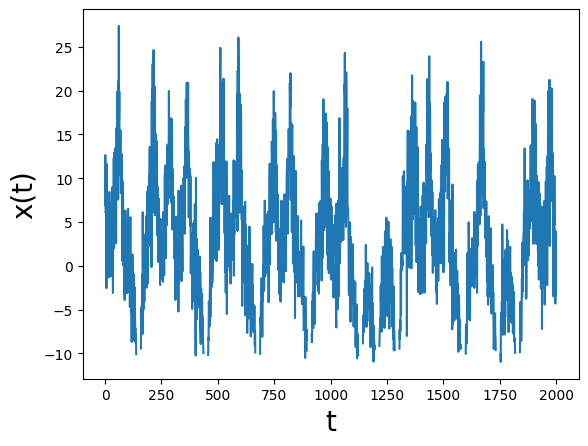

In [5]:
plt.plot(time_series)
plt.xlabel('t', size=20)
plt.ylabel('x(t)', size=20)

### 2) Linear Regression
Here, the function  **`linregress`** from SciPy is used to find the true coefficients of the linear regression of $x(t)$ and $x(t+1)$
Thus, later on it is possible to compare the coefficients predicted by the neural network with these ones.
Mathematically:

Given the vector of points
$$
\mathbf{x} = [x_1, x_2, x_3, \dots, x_n]
$$
$$
\mathbf{y} = [y_1, y_2, y_3, \dots, y_n]
$$ 
we use linear regression to determine the best-fitting line $( \hat{y} )$, defined as:

$$
\mathbf{\hat{y}} = b + a \cdot \mathbf{x}
$$

Where:
- ` a ` is the slope of the line,
- ` b ` is the y-intercept.

Using the `linregress` method, we calculate these parameters and also retrieve:
- ` r `: The correlation coefficient,
- ` p `: The p-value for the null hypothesis,
- $\text{std\_err}$: The standard error of the slope.

The residuals $r_i$ are calculated as the difference between the observed $y_i$ and predicted $ \hat{y}_i $:

$$
r_i = y_i - \hat{y}_i
$$

The standard error of the residuals $( \text{SE} )$ is computed as:

$$
\text{SE} = \sqrt{\frac{\sum_{i=1}^n r_i^2}{n - 2}}
$$

In [6]:
time = np.array([t.T])[~np.isnan(time_series.T)]
data = time_series.T[~np.isnan(time_series.T)]
x = data[:-1]
y = data[1:]
time = time[:-1]

slope, intercept, r_value, p_value, std_err = linregress(x, y)
line_ = intercept + slope * x

print("Slope (a): ", slope)
print("Intercept (b): ", intercept)

residuals = y - line_
se = np.sqrt(np.sum(residuals**2) / (len(x) - 2))

print("Standard error (sigma): ", se)

Slope (a):  0.7179033063228039
Intercept (b):  0.9462515421834921
Standard error (sigma):  4.994632483310351


Text(0, 0.5, 'x(t+1)')

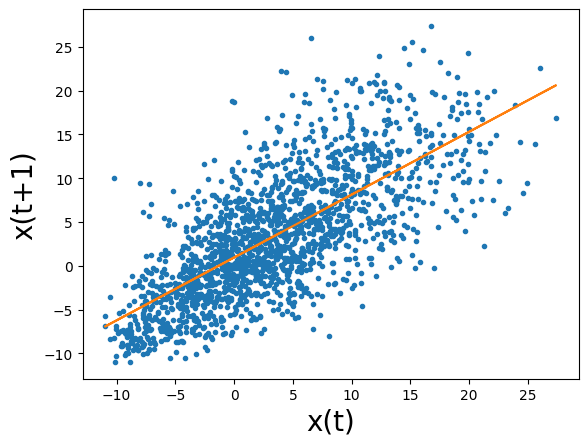

In [7]:
plt.plot(time_series[:-1], time_series[1:], '.')
plt.plot(x, line_)
plt.xlabel('x(t)', size=20)
plt.ylabel('x(t+1)', size=20)

### 3) First Part: constant variance, parametric

Now, given the true values values of `a`, `b` and `SE`, it will be implemented a simple neural network to predict these three values.

The `LinearModel` represents a simple linear regression model:
$$
y_{\text{pred}} = a \cdot x + b
$$

#### Implementation:
- **Fully Connected Layer (`nn.Linear`)**:
  - A single fully connected layer maps the input $x$ to the predicted output $( y_{\text{pred}} )$.
  - Internally, it learns the parameters $a$ (weight) and $b$ (bias).

---

The `NormalLikelihoodLoss` implements a loss function based on the Gaussian (normal) likelihood, allowing the model to learn both the mean and the variance of the data.

Key Components:
- **Trainable Variance $ \sigma $**:
  - The variance $ \sigma^2 $ is modeled as a trainable parameter using `nn.Parameter`.
  - To ensure positivity, $ \sigma $ is exponentiated using `torch.exp`.

- **Negative Log-Likelihood Loss**:
  The loss function is derived from the negative log-likelihood of a normal distribution:
  $$
  \mathcal{L} = \frac{n}{2} \log(2 \pi \sigma^2) + \frac{\sum (y_{\text{true}} - y_{\text{pred}})^2}{2 \sigma^2}
  $$
  - **First Term**:
    $$
    \frac{n}{2} \log(2 \pi \sigma^2)
    $$
    Represents the normalization constant for the Gaussian likelihood.
  - **Second Term**:
    $$
    \frac{\sum (y_{\text{true}} - y_{\text{pred}})^2}{2 \sigma^2}
    $$
    Measures the squared error between predictions and true values, weighted by $\sigma^2$.

$$
\begin{align*}
\mathcal{L}&= \prod_{i=1}^n f(x_i \mid \hat{x}_i, \sigma^2) \\
&= \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x_i - \hat{x}_i)^2}{2\sigma^2}\right) \\
& = -\frac{n}{2} \ln(2\pi\sigma^2) - \frac{1}{2}\sum_{i=1}^n \frac{(x_i - \hat{x_i})^2}{2\sigma^2}\\
\end{align*}
$$

In [8]:
class LinearModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(1, 1)

    def forward(self, x):
        x = self.fc(x)
        return x

In [9]:
class NormalLikelihoodLoss(nn.Module):

    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(torch.tensor(0.0))

    def forward(self, y_pred, y_true):
        sigma = torch.exp(self.sigma)

        n = len(y_true)
        first_term = (n / 2) * torch.log(2* torch.pi * sigma**2)
        second_term = torch.sum((y_true - y_pred) ** 2) / (2 * sigma ** 2)
        return first_term + second_term

In [10]:
linear_model = LinearModel()
criterion1 = NormalLikelihoodLoss()
optimiser = torch.optim.Adam(list(linear_model.parameters()) + [criterion1.sigma])

In [11]:
summary(linear_model, (1,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 1]               2
Total params: 2
Trainable params: 2
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [12]:
x_tensor = torch.tensor(x, dtype=torch.float).view(1798, 1)
y_tensor = torch.tensor(y, dtype=torch.float).view(1798, 1)

In [13]:
epochs = 20000
losses = []

for _ in range(epochs):

    y_pred = linear_model(x_tensor)
    loss = criterion1(y_pred, y_tensor)
    losses.append(loss.detach().numpy())

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

In [14]:
a, b = linear_model.parameters()

print("True a: ", slope)
print("Estimated a: ", a)
print("Error: ", abs(slope - a.item()))

print("\n##############\n")

print("True b: ", intercept)
print("Estimated b: ", b)
print("Error: ", abs(intercept - b.item()))

print("\n##############\n")
print("True sigma: ", se)
print("Estimated sigma: ", torch.exp(criterion1.sigma))
print("Error = ", abs(se - torch.exp(criterion1.sigma).item()))

True a:  0.7179033063228039
Estimated a:  Parameter containing:
tensor([[0.7179]], requires_grad=True)
Error:  9.698161718141307e-09

##############

True b:  0.9462515421834921
Estimated b:  Parameter containing:
tensor([0.9463], requires_grad=True)
Error:  9.021434532741068e-08

##############

True sigma:  4.994632483310351
Estimated sigma:  tensor(4.9919, grad_fn=<ExpBackward0>)
Error =  0.0027782924839350187


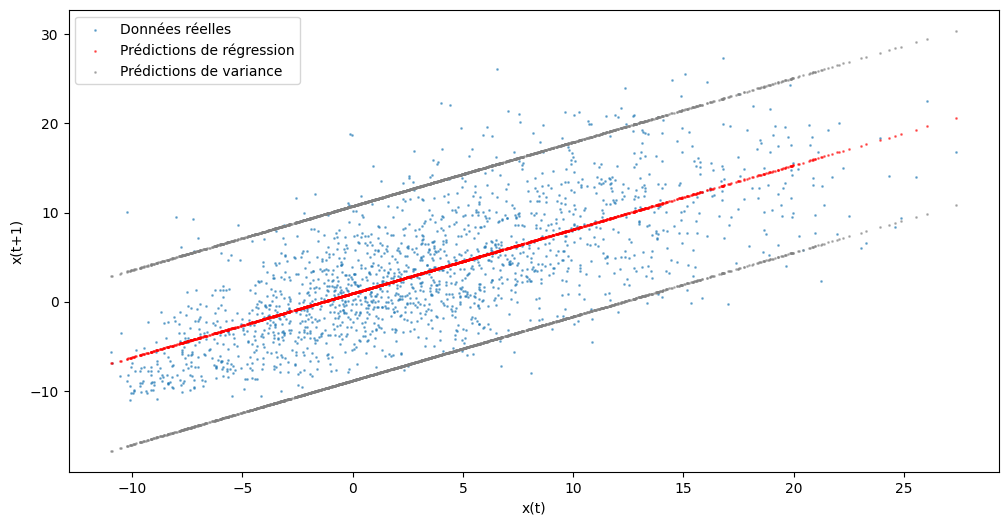

In [15]:
y_pred = a * x_tensor + b
sigma = float(torch.exp(criterion1.sigma))

x_float = x_tensor.detach().numpy()
y_float = y_tensor.detach().numpy()
y_pred_float = y_pred.detach().numpy()

plt.figure(figsize=(12, 6))
plt.scatter(x_float, y_float, s=1, alpha=0.5, label='Données réelles')
plt.scatter(x_float, y_pred_float, s=1, alpha=0.5, label='Prédictions de régression', color='red')
plt.scatter(x_float, y_pred_float - 1.96 * sigma, s=1, alpha=0.5, label='Prédictions de variance', color='grey')
plt.scatter(x_float, y_pred_float + 1.96 * sigma, s=1, alpha=0.5, color='grey')
plt.xlabel('x(t)')
plt.ylabel('x(t+1)')
plt.legend()

## 4) Second Part: Non constant variance, parametric

Now, we will implement a model that aims to obtain the coefficients of the variance function and the linear regression function. However, we need to rewrite the loss function to adapt it to this case. Since the manipulation of the likelihood function is more complex and requires some adjustments, since the variance depends on time. Thus,
$$
\begin{align*}
\mathcal{L}(x_1, \dots, x_n \mid \hat{x}, \sigma(i)) &= \prod_{i=1}^n f(x_i \mid \hat{x}_i, \sigma^2(i)) \\
&= \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma(i)^2}} \exp\left(-\frac{(x_i - \hat{x}_i)^2}{2\sigma(i)^2}\right) \\
& = -\sum_{i=1}^n \frac{1}{2} \ln(2\pi\sigma(i)^2) - \frac{1}{2}\sum_{i=1}^n \frac{(x_i - \hat{x_i})^2}{2\sigma(i)^2}\\
\end{align*}
$$



In [16]:
class NormalLikelihoodLoss2(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, y_pred, y_true, log_sigma):

        sigma = torch.exp(log_sigma)
        
        first_term = torch.sum(
            torch.log(2 * torch.pi * sigma ** 2)
        )
        second_term = torch.sum(
            ((y_true - y_pred) ** 2) / 
            (2 * sigma ** 2)
        )
        nll = first_term + second_term
        return 0.5 * nll
    
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(1, 1)
        self.fc4 = nn.Linear(1, 256)
        self.fc5 = nn.Linear(256, 1) 
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        log_var = self.relu(self.fc5(self.relu(self.fc4(x))))
        return x, log_var

In [17]:
linear_model2 = MLPModel()
criterion2 = NormalLikelihoodLoss2()
optimiser2 = torch.optim.Adam(linear_model2.parameters())

In [18]:
epochs = 5000
losses = []

for _ in range(epochs):

    y_pred, log_sigma = linear_model2(x_tensor)
    loss = criterion2(y_tensor, y_pred, log_sigma)
    losses.append(loss.detach().numpy())

    optimiser2.zero_grad()
    loss.backward()
    optimiser2.step()

In [48]:
a, b, c, d, e, f = linear_model2.named_parameters()

In [59]:
a, b

(('fc1.weight',
  Parameter containing:
  tensor([[0.7392]], requires_grad=True)),
 ('fc1.bias',
  Parameter containing:
  tensor([0.8138], requires_grad=True)))

Text(0, 0.5, 'x(t+1)')

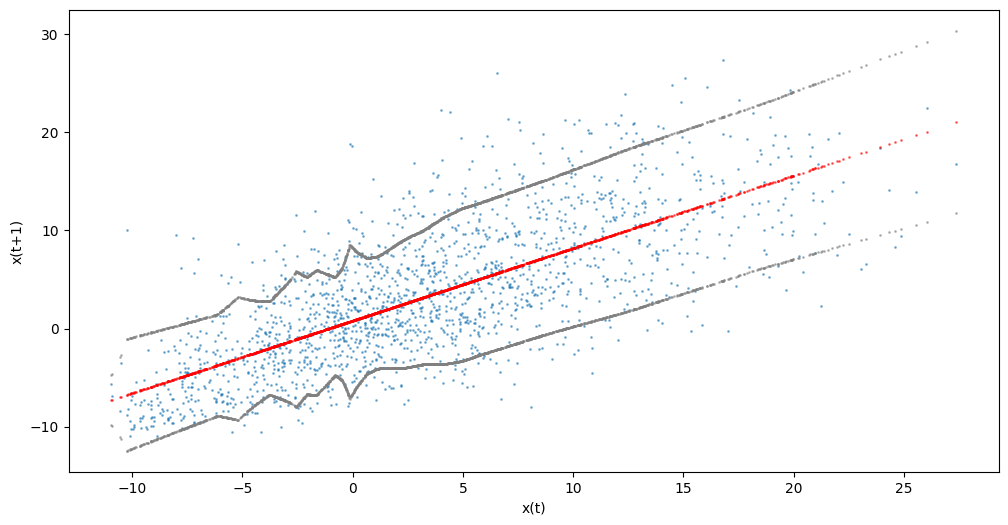

In [61]:

y_pred = a[1].detach().numpy() * x_tensor.detach().numpy().flatten() + b[1].detach().numpy()

x, log_var_pred = linear_model2(x_tensor)
sigma = torch.exp(log_var_pred).detach().numpy().flatten()


# Tracer les données réelles et les prédictions
plt.figure(figsize=(12, 6))
plt.scatter(x_tensor.detach().numpy(), y_tensor.detach().numpy(), s=1, alpha=0.5, label='Données réelles')
plt.scatter(x_tensor.detach().numpy(), y_pred, s=1, alpha=0.5, label='Prédictions de régression', color='red')
plt.scatter(x_tensor.detach().numpy(), y_pred - 1.96 * sigma, s=1, alpha=0.5, label='Prédictions de variance', color='grey')
plt.scatter(x_tensor.detach().numpy(), y_pred + 1.96 * sigma, s=1, alpha=0.5, color='grey')
plt.xlabel('x(t)')
plt.ylabel('x(t+1)')

## 5) Third Part: Non constant variance, non-parametric

In this approach, the goal is to estimate variance non-parametrically. Unlike the previous methods, we set aside the objective of estimating the straight line. Instead, since estimating the straight line requires a parametric approach, we focus on estimating various quantiles, including the 50th and 95th percentiles.

To achieve this, we use the pinball loss function, as described below.

$$
\begin{align*}
L_\tau(y,z)&=(y-z)\tau \enspace\enspace\enspace\enspace\enspace\enspace si\enspace y\geq z \\
&=(z-y)(1-\tau) \enspace si \enspace z > y
\end{align*}
$$

$y$ represents the actual value, $z$ is the predicted quantile, and $\tau$ is the targeted quantile.

To better understand the role of $\tau$ in this loss function, it is important to note that in a real application, the sum of all $y_i$ values is considered.

$$
\begin{align*}
\text{Total Loss}(z) &= \sum_{i=1}^n L_\tau(y_i, z) \\
&= \tau \sum_{i: y_i \geq z} (y_i - z) + (1 - \tau) \sum_{i: y_i < z} (z - y_i)
\end{align*}
$$

Here, it becomes clearer that $\tau$ weights errors differently depending on their position relative to $z$. Errors above $z$ are penalized by a factor of $\tau$, while errors below $z$ are penalized by a factor of $1-\tau$. For example, if $\tau$ equals 0.95, all $y_i$ values below $z$ will incur a higher cost, prompting an increase in the value of $z$ to minimize the total loss. This aligns with our intuition, as the true value of the 0.95 quantile is expected to be higher within the dataset.

In [24]:
def quantile_loss(q, y, tau):
    error = y - q
    return torch.sum(torch.maximum(tau * error, (tau - 1) * error))


class QuantileMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.q5 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Softmax(),
            nn.Linear(hidden_dim, 1)
        )
        self.q50 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Softmax(),
            nn.Linear(hidden_dim, 1)
        )
        self.q95 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Softmax(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        q5 = self.q5(x)
        q50 = self.q50(x)
        q95 = self.q95(x)
        return q5, q50, q95

In [25]:
qmodel = QuantileMLP(input_dim=1, hidden_dim=64)
optimizer = torch.optim.Adam(qmodel.parameters(), lr=0.01)

In [26]:
epochs = 10000
losses = []

for _ in range(epochs):
    q5, q50, q95 = qmodel(x_tensor)
    loss = (
        quantile_loss(q5, y_tensor, 0.05) +
        quantile_loss(q50, y_tensor, 0.5) +
        quantile_loss(q95, y_tensor, 0.95)
    )
    losses.append(loss.detach().numpy())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


c:\Users\bensi\pyIMT\.venv\Lib\site-packages\torch\nn\modules\module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [27]:
q5_forecast, q50_forecast, q95_forecast = qmodel(x_tensor)

q5 = q5.cpu().detach().numpy().flatten()
q50 = q50.cpu().detach().numpy().flatten()
q95 = q95.cpu().detach().numpy().flatten()

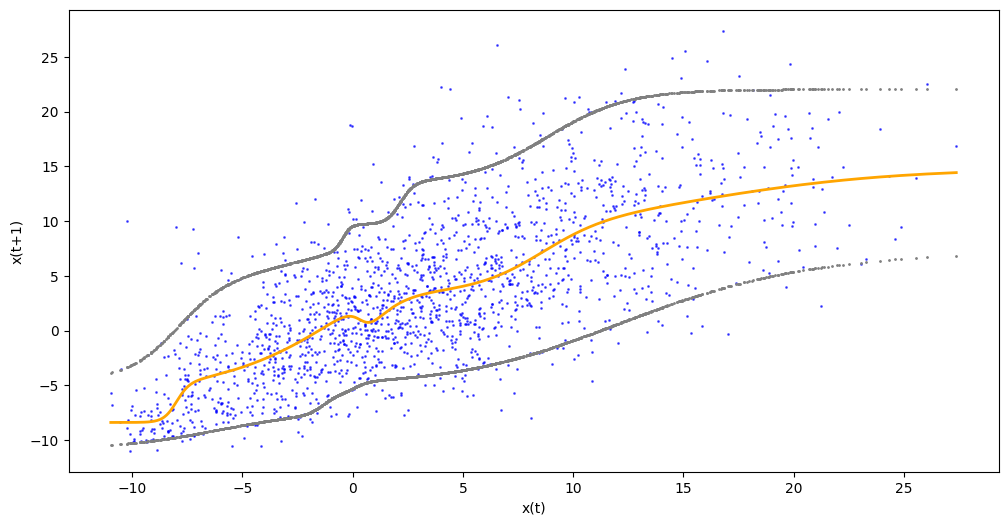

In [28]:
sorted_indices = x_tensor.argsort(axis=0).flatten()
x_train_sorted = x_tensor[sorted_indices]
q5_sorted = q5_forecast[sorted_indices]
q50_sorted = q50_forecast[sorted_indices]
q95_sorted = q95_forecast[sorted_indices]

plt.figure(figsize=(12, 6))
plt.scatter(x_tensor, y_tensor, s=1, alpha=0.6, label="Données d'entraînement", color="blue")
plt.plot(x_train_sorted, q50_sorted.detach().numpy(), label="Médiane (q50)", color="orange", linewidth=2)
plt.scatter(x_train_sorted, q5_sorted.detach().numpy(), color='gray', label='Quantiles (5%)', s=1)
plt.scatter(x_train_sorted, q95_sorted.detach().numpy(), color='gray', label='Quantiles (95%)', s=1)

plt.xlabel("x(t)")
plt.ylabel("x(t+1)")
plt.show()